In [4]:
import shutil

if os.path.exists(os.path.join("metastore_db")):
    shutil.rmtree(os.path.join("metastore_db"))
if os.path.exists(os.path.join("derby.log")):
    os.remove(os.path.join("derby.log"))

In [5]:
warehouse_location="database"
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

In [6]:
spark.sql("show tables;").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



In [9]:
import json
import logging
import os
import datetime
import requests



DATA_SOURCE_URL = f"https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/" \
                  f"?date_received_max=<todate>&date_received_min=<fromdate>" \
                  f"&field=all&format=json"

def get_from_date_to_date():
    from_date = "2023-01-01"
    from_date = datetime.datetime.strptime(from_date, "%Y-%m-%d")
    to_date = "2023-01-05"
    to_date = datetime.datetime.strptime(to_date, "%Y-%m-%d")   

    #to_date = datetime.datetime.now() #current date

    response = {
        "form_date": from_date.strftime("%Y-%m-%d"),
        "to_date": to_date.strftime("%Y-%m-%d"),
        "from_date_obj": from_date,
        "to_date_obj": to_date
    }
    logging.info(f"From date and to date {response}")
    return response

print(get_from_date_to_date())



{'form_date': '2023-01-01', 'to_date': '2023-01-05', 'from_date_obj': datetime.datetime(2023, 1, 1, 0, 0), 'to_date_obj': datetime.datetime(2023, 1, 5, 0, 0)}


In [13]:
def download_data():
    from_date, to_date, from_date_obj, to_date_obj = get_from_date_to_date().values()
    if to_date==from_date:
        return None
    url = DATA_SOURCE_URL.replace("<todate>", to_date).replace("<fromdate>", from_date)
    print(url)
    print(f"Started downloading data")
    
    data = requests.get(url, params={'User-agent': f'your bot '})

    finance_complaint_data = list(map(lambda x: x["_source"],
                                    filter(lambda x: "_source" in x.keys(),
                                            json.loads(data.content))))
    if len(finance_complaint_data)==0:
        return None
    #save_from_date_to_date({"from_date": from_date_obj, "to_date": to_date_obj})

    return finance_complaint_data

In [14]:
tmp = download_data()
print(len(tmp))

https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2023-01-05&date_received_min=2023-01-01&field=all&format=json
Started downloading data
14533


In [25]:
table_name = "finance_complaint"
def get_dataframe():

    data = download_data()
    if data is None:
        print("data not available")
        return None
    df = spark.createDataFrame(data)
    return df

df=get_dataframe()


https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2023-01-05&date_received_min=2023-01-01&field=all&format=json
Started downloading data


In [16]:
df.show(10)

+--------------------+-----------------------+--------------------+------------+-----------------------+-------------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+-------------+--------------+------+--------+
|             company|company_public_response|    company_response|complaint_id|complaint_what_happened|consumer_consent_provided|consumer_disputed|       date_received|date_sent_to_company|               issue|             product|state|           sub_issue|         sub_product|submitted_via|          tags|timely|zip_code|
+--------------------+-----------------------+--------------------+------------+-----------------------+-------------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+-------------+--------------+------+--------+
|JPMORGAN CHASE & CO.|

In [26]:
df.printSchema()

root
 |-- company: string (nullable = true)
 |-- company_public_response: string (nullable = true)
 |-- company_response: string (nullable = true)
 |-- complaint_id: string (nullable = true)
 |-- complaint_what_happened: string (nullable = true)
 |-- consumer_consent_provided: string (nullable = true)
 |-- consumer_disputed: string (nullable = true)
 |-- date_received: string (nullable = true)
 |-- date_sent_to_company: string (nullable = true)
 |-- issue: string (nullable = true)
 |-- product: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sub_issue: string (nullable = true)
 |-- sub_product: string (nullable = true)
 |-- submitted_via: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- timely: string (nullable = true)
 |-- zip_code: string (nullable = true)



In [27]:
if spark.sql(f"show tables").filter(f"tableName='{table_name}'").count()>0:
    print(f"Table already exist")
    spark.sql(f"drop table {table_name}")

In [28]:
df.write.saveAsTable(table_name)

AnalysisException: org.apache.hadoop.hive.ql.metadata.HiveException: MetaException(message:Couldnt obtain a new sequence (unique id) : Container 384 not found.)

In [29]:
spark.sql("show databases;").show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [23]:
spark.sql("use default;").show()

++
||
++
++



In [30]:
spark.sql("show tables;").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



In [31]:
df.createOrReplaceTempView("finance_complaint")

In [32]:
spark.sql("select * from finance_complaint limit 10").show()

+--------------------+-----------------------+--------------------+------------+-----------------------+-------------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+-------------+--------------+------+--------+
|             company|company_public_response|    company_response|complaint_id|complaint_what_happened|consumer_consent_provided|consumer_disputed|       date_received|date_sent_to_company|               issue|             product|state|           sub_issue|         sub_product|submitted_via|          tags|timely|zip_code|
+--------------------+-----------------------+--------------------+------------+-----------------------+-------------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+-------------+--------------+------+--------+
|JPMORGAN CHASE & CO.|

In [33]:
spark.sql("""select  company,
 company_public_response,
 company_response,
 complaint_id from finance_complaint  limit 10""").show()





+--------------------+-----------------------+--------------------+------------+
|             company|company_public_response|    company_response|complaint_id|
+--------------------+-----------------------+--------------------+------------+
|JPMORGAN CHASE & CO.|                   null|Closed with monet...|     6397795|
|Home Point Financ...|                   null|Closed with expla...|     6397628|
|       EQUIFAX, INC.|                   null|Closed with expla...|     6394348|
|Experian Informat...|                   null|         In progress|     6389771|
|       EQUIFAX, INC.|                   null|Closed with expla...|     6396523|
|       EQUIFAX, INC.|                   null|Closed with expla...|     6389205|
|CARRINGTON MORTGA...|                   null|Closed with expla...|     6403569|
|Experian Informat...|   Company has respo...|Closed with expla...|     6395045|
|       EQUIFAX, INC.|                   null|         In progress|     6402807|
|TRANSUNION INTERM...|      

In [34]:
#Top 5 Companies with complaint


spark.sql("""
select company,count(*) as n_complaint from finance_complaint
group by company order by  n_complaint desc limit 5

""").show()

+--------------------+-----------+
|             company|n_complaint|
+--------------------+-----------+
|TRANSUNION INTERM...|       3714|
|Experian Informat...|       3611|
|       EQUIFAX, INC.|       3585|
|WELLS FARGO & COM...|        189|
|CAPITAL ONE FINAN...|        186|
+--------------------+-----------+



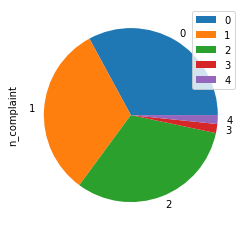

In [35]:
#Creating Bar chart

spark.sql("""
select company,count(*) as n_complaint from finance_complaint
group by company order by  n_complaint desc limit 5

""").toPandas().plot(kind="pie",y="n_complaint",)


In [36]:
df = spark.sql("select * from finance_complaint")

In [37]:
#Number of complaint for each product

spark.sql("""
select product,count(*) as n_complaint from finance_complaint
group by product order by  n_complaint desc limit 5

""").show(truncate=False)

+----------------------------------------------------------------------------+-----------+
|product                                                                     |n_complaint|
+----------------------------------------------------------------------------+-----------+
|Credit reporting, credit repair services, or other personal consumer reports|11684      |
|Debt collection                                                             |895        |
|Credit card or prepaid card                                                 |617        |
|Checking or savings account                                                 |512        |
|Mortgage                                                                    |307        |
+----------------------------------------------------------------------------+-----------+



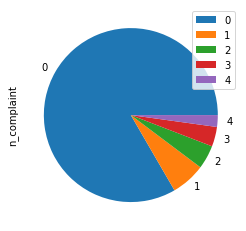

In [38]:
spark.sql("""
select product,count(*) as n_complaint from finance_complaint
group by product order by  n_complaint desc limit 5

""").toPandas().plot(kind="pie",y="n_complaint",)

In [39]:
#Number of unique product


spark.sql("""
with res as(
select product from finance_complaint
group by product )
select count(*) from res;


""").show()

+--------+
|count(1)|
+--------+
|       9|
+--------+



In [40]:
spark.sql("""
select product,count(*) as n_complaint from finance_complaint
group by product order by  n_complaint desc

""").show(truncate=False)

+----------------------------------------------------------------------------+-----------+
|product                                                                     |n_complaint|
+----------------------------------------------------------------------------+-----------+
|Credit reporting, credit repair services, or other personal consumer reports|11684      |
|Debt collection                                                             |895        |
|Credit card or prepaid card                                                 |617        |
|Checking or savings account                                                 |512        |
|Mortgage                                                                    |307        |
|Money transfer, virtual currency, or money service                          |189        |
|Vehicle loan or lease                                                       |154        |
|Student loan                                                                |91         |